## 1. Environment Setup

Setting up the environment with all necessary dependencies and GPU configuration.

In [1]:
%pip install -q vaderSentiment

Note: you may need to restart the kernel to use updated packages.


In [2]:
import warnings
import logging
import random
from pathlib import Path
from typing import Dict, List, Union
from dataclasses import dataclass
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import gc
import numpy as np
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    confusion_matrix, classification_report
)
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.amp import GradScaler, autocast
from transformers import (
    AutoTokenizer,
    BertModel,
    get_linear_schedule_with_warmup,
)
from datasets import Dataset, load_dataset
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from torch.utils.tensorboard import SummaryWriter
import nltk
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

warnings.filterwarnings('ignore')
logging.getLogger('transformers').setLevel(logging.ERROR)

2025-08-08 19:03:57.586978: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754679837.612030    7333 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754679837.620031    7333 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-08 19:03:57.647172: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
try:
    nltk.download('punkt', quiet=True)
    nltk.download('stopwords', quiet=True)
    nltk.download('vader_lexicon', quiet=True)
    print("NLTK data downloaded")
except Exception as e:
    print(f"Warning: Could not download NLTK data: {e}")

NLTK data downloaded


In [4]:
def setup_device_and_memory():    
    if torch.cuda.is_available():
        device = torch.device('cuda')        
        torch.cuda.empty_cache()
        torch.backends.cudnn.benchmark = True
        torch.backends.cudnn.deterministic = False
        
    else:
        device = torch.device('cpu')
        print("CUDA not available. Using CPU.")
        
    return device

def set_random_seeds(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    print(f"Random seeds set to {seed}")

device = setup_device_and_memory()
set_random_seeds(42)

Random seeds set to 42


## 2. Configuration

In [5]:
@dataclass
class Config:
    dataset_size: int = 500000 
    train_split: float = 0.8
    val_split: float = 0.1
    test_split: float = 0.1
    max_length: int = 512
    
    bert_model_name: str = "bert-base-uncased"
    hidden_size: int = 768
    lstm_hidden_size: int = 256
    num_lstm_layers: int = 2
    dropout_rate: float = 0.3
    num_classes: int = 3
    
    batch_size: int = 16
    gradient_accumulation_steps: int = 2
    effective_batch_size: int = batch_size * gradient_accumulation_steps
    num_epochs: int = 3
    learning_rate_bert: float = 2e-5
    learning_rate_lstm: float = 1e-3
    weight_decay: float = 0.01
    warmup_steps: int = 1000
    early_stopping_patience: int = 3
    
    use_mixed_precision: bool = True
    dataloader_num_workers: int = 0
    pin_memory: bool = True
    
    data_dir: str = "data"
    models_dir: str = "models"
    logs_dir: str = "logs"
    results_dir: str = "results"
    
    slang_confidence_threshold: float = 0.7
    
    def __post_init__(self):
        for dir_path in [self.data_dir, self.models_dir, self.logs_dir, self.results_dir]:
            Path(dir_path).mkdir(exist_ok=True)

config = Config()
print("Config:")
print(f"   Dataset size: {config.dataset_size:,}")
print(f"   Batch size: {config.batch_size} (effective: {config.effective_batch_size})")
print(f"   Max sequence length: {config.max_length}")
print(f"   LSTM hidden size: {config.lstm_hidden_size}")
print(f"   Mixed precision: {config.use_mixed_precision}")

Config:
   Dataset size: 500,000
   Batch size: 16 (effective: 32)
   Max sequence length: 512
   LSTM hidden size: 256
   Mixed precision: True


## 3. Dataset Acquisition and Preprocessing

Loading and preprocessing multiple datasets to create a comprehensive slang-rich corpus.

In [6]:
class SlangProcessor:    
    def __init__(self):
        self.slang_mappings = {
            'lit': 'excellent',
            'fire': 'amazing',
            'dope': 'cool',
            'sick': 'awesome',
            'tight': 'cool',
            'fresh': 'cool',
            'bomb': 'excellent',
            'legit': 'legitimate',
            'solid': 'good',
            'clutch': 'perfect',
            'banging': 'excellent',
            'slaps': 'excellent',
            'bussin': 'excellent',
            'no cap': 'no lie',
            'periodt': 'period',
            'slay': 'excel',
            'goat': 'greatest',
            'chef kiss': 'perfect',
            'hits different': 'exceptional',
            'trash': 'bad',
            'wack': 'bad',
            'sus': 'suspicious',
            'mid': 'mediocre',
            'cap': 'lie',
            'L': 'loss',
            'ratio': 'disagree',
            'cringe': 'embarrassing',
            'yikes': 'bad',
            'oof': 'bad',
            'rip': 'failed',
            'dead': 'broken',
            'bruh': 'disappointed',
            'bet': 'okay',
            'facts': 'true',
            'mood': 'relatable',
            'vibe': 'feeling',
            'stan': 'support',
            'flex': 'show off',
            'lowkey': 'somewhat',
            'highkey': 'definitely',
            'deadass': 'seriously',
            'fr': 'for real',
            'ngl': 'not gonna lie',
            'tbh': 'to be honest',
            'imo': 'in my opinion',
            'smh': 'shaking my head',
            'fam': 'family',
            'squad': 'group',
            'crew': 'group',
            'vibes': 'atmosphere',
            'salty': 'bitter',
            'basic': 'ordinary'
        }
        
        self.slang_pattern = re.compile(
            r'\b(' + '|'.join(re.escape(term) for term in self.slang_mappings.keys()) + r')\b',
            re.IGNORECASE
        )
    
    def detect_slang_tokens(self, text: str) -> List[Dict[str, Union[str, bool, float]]]:
        tokens = text.lower().split()
        slang_info = []
        
        for token in tokens:
            clean_token = re.sub(r'[^\w\s]', '', token)
            
            is_slang = clean_token in self.slang_mappings
            confidence = 0.95 if is_slang else 0.05
            
            slang_info.append({
                'token': token,
                'clean_token': clean_token,
                'is_slang': is_slang,
                'confidence': confidence,
                'normalized': self.slang_mappings.get(clean_token, clean_token)
            })
        
        return slang_info
    
    def normalize_text(self, text: str) -> str:
        def replace_slang(match):
            term = match.group(0).lower()
            return self.slang_mappings.get(term, term)
        
        return self.slang_pattern.sub(replace_slang, text)
    
    def get_slang_density(self, text: str) -> float:
        tokens = text.lower().split()
        if not tokens:
            return 0.0
        
        slang_count = sum(1 for token in tokens 
                         if re.sub(r'[^\w\s]', '', token) in self.slang_mappings)
        return slang_count / len(tokens)

slang_processor = SlangProcessor()
print(f"Slang processor initialized with {len(slang_processor.slang_mappings)} mappings")
print(f"Sample mappings: {dict(list(slang_processor.slang_mappings.items())[:5])}")

Slang processor initialized with 52 mappings
Sample mappings: {'lit': 'excellent', 'fire': 'amazing', 'dope': 'cool', 'sick': 'awesome', 'tight': 'cool'}


In [7]:
class DatasetLoader:    
    def __init__(self, config: Config, slang_processor: SlangProcessor):
        self.config = config
        self.slang_processor = slang_processor
        self.label_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}
        self.reverse_label_mapping = {v: k for k, v in self.label_mapping.items()}
    
    def clean_text(self, text: str) -> str:
        if not isinstance(text, str):
            return ""
        
        text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text)
        
        text = re.sub(r'\S+@\S+', '', text)
        
        text = re.sub(r'\s+', ' ', text)
        
        text = re.sub(r'[^\w\s.,!?;:()-]', '', text)
        
        return text.strip()
    
    def load_amazon_reviews(self, subset_size: int = 200000) -> pd.DataFrame:
        try:
            print("Loading Amazon Reviews dataset")
            
            dataset = load_dataset("amazon_polarity", split=f"train[:{subset_size}]")
            
            df = pd.DataFrame({
                'text': dataset['content'],
                'label': ['positive' if label == 1 else 'negative' for label in dataset['label']],
                'source': 'amazon'
            })
            
            print(f"Loaded {len(df):,} Amazon reviews")
            return df
            
        except Exception as e:
            print(f"Error loading Amazon reviews: {e}")
            return pd.DataFrame()
    
    def load_yelp_reviews(self, subset_size: int = 150000) -> pd.DataFrame:
        try:
            print("Loading Yelp Reviews dataset...")
            
            dataset = load_dataset("yelp_polarity", split=f"train[:{subset_size}]")
            
            df = pd.DataFrame({
                'text': dataset['text'],
                'label': ['positive' if label == 1 else 'negative' for label in dataset['label']],
                'source': 'yelp'
            })
            
            print(f"Loaded {len(df):,} Yelp reviews")
            return df
            
        except Exception as e:
            print(f"Error loading Yelp reviews: {e}")
            return pd.DataFrame()
    
    def load_twitter_sentiment(self, subset_size: int = 100000) -> pd.DataFrame:
        try:
            print("Loading Twitter sentiment dataset...")
            
            dataset = load_dataset("tweet_eval", "sentiment", split=f"train[:{subset_size}]")
            
            label_map = {0: 'negative', 1: 'neutral', 2: 'positive'}
            
            df = pd.DataFrame({
                'text': dataset['text'],
                'label': [label_map[label] for label in dataset['label']],
                'source': 'twitter'
            })
            
            print(f"Loaded {len(df):,} Twitter posts")
            return df
            
        except Exception as e:
            print(f"Error loading Twitter sentiment: {e}")
            return pd.DataFrame()
    
    def create_synthetic_slang_data(self, size: int = 50000) -> pd.DataFrame:       
        positive_templates = [
            "This product is absolutely {slang}! Highly recommend it.",
            "No cap, this is {slang}. Best purchase ever!",
            "This {slang} product exceeded my expectations.",
            "Straight up {slang}! Will definitely buy again.",
            "This product {slang} different, in the best way possible."
        ]
        
        negative_templates = [
            "This product is straight {slang}. Don't waste your money.",
            "Bruh, this is so {slang}. Total disappointment.",
            "This product is {slang} and overpriced.",
            "Yikes, this is {slang}. Returning immediately.",
            "This {slang} product broke after one day."
        ]
        
        neutral_templates = [
            "This product is {slang}, nothing special but works.",
            "It's {slang} I guess. Does what it's supposed to do.",
            "The product is {slang}. Average quality for the price.",
            "Lowkey {slang} but gets the job done.",
            "This product is {slang}. Not bad, not great."
        ]
        
        positive_slang = ['lit', 'fire', 'dope', 'sick', 'bomb', 'legit', 'solid', 'clutch']
        negative_slang = ['trash', 'wack', 'mid', 'cringe', 'sus']
        neutral_slang = ['basic', 'mid', 'whatever', 'meh']
        
        synthetic_data = []
        
        for _ in range(size // 3):
            template = random.choice(positive_templates)
            slang_term = random.choice(positive_slang)
            text = template.format(slang=slang_term)
            synthetic_data.append({'text': text, 'label': 'positive', 'source': 'synthetic'})
            
            template = random.choice(negative_templates)
            slang_term = random.choice(negative_slang)
            text = template.format(slang=slang_term)
            synthetic_data.append({'text': text, 'label': 'negative', 'source': 'synthetic'})
            
            template = random.choice(neutral_templates)
            slang_term = random.choice(neutral_slang)
            text = template.format(slang=slang_term)
            synthetic_data.append({'text': text, 'label': 'neutral', 'source': 'synthetic'})
        
        df = pd.DataFrame(synthetic_data)
        print(f"Created {len(df):,} synthetic examples")
        return df

In [8]:
def load_and_combine_datasets(self) -> pd.DataFrame:
        print("Loading and combining datasets...")
        
        datasets = []
        
        amazon_df = self.load_amazon_reviews(200000)
        if not amazon_df.empty:
            datasets.append(amazon_df)
        
        yelp_df = self.load_yelp_reviews(150000)
        if not yelp_df.empty:
            datasets.append(yelp_df)
        
        twitter_df = self.load_twitter_sentiment(100000)
        if not twitter_df.empty:
            datasets.append(twitter_df)
        
        synthetic_df = self.create_synthetic_slang_data(50000)
        if not synthetic_df.empty:
            datasets.append(synthetic_df)
        
        if not datasets:
            raise ValueError("No datasets could be loaded!")
        
        combined_df = pd.concat(datasets, ignore_index=True)
        
        print("Cleaning and preprocessing text...")
        combined_df['text'] = combined_df['text'].apply(self.clean_text)
        
        combined_df = combined_df[combined_df['text'].str.len() > 10]
        
        print("Calculating slang density...")
        combined_df['slang_density'] = combined_df['text'].apply(
            self.slang_processor.get_slang_density
        )
        
        slang_rich_df = combined_df[combined_df['slang_density'] > 0]
        regular_df = combined_df[combined_df['slang_density'] == 0].sample(
            min(len(slang_rich_df), len(combined_df) - len(slang_rich_df))
        )
        
        final_df = pd.concat([slang_rich_df, regular_df], ignore_index=True)
        
        final_df = final_df.sample(frac=1, random_state=42).reset_index(drop=True)
        
        if len(final_df) > self.config.dataset_size:
            final_df = final_df.head(self.config.dataset_size)
        
        print(f"Final dataset statistics:")
        print(f"Total samples: {len(final_df):,}")
        print(f"Label distribution:")
        print(final_df['label'].value_counts().to_string())
        print(f"Source distribution:")
        print(final_df['source'].value_counts().to_string())
        print(f"Average slang density: {final_df['slang_density'].mean():.3f}")
        print(f"Samples with slang: {(final_df['slang_density'] > 0).sum():,}")
        
        return final_df

dataset_loader = DatasetLoader(config, slang_processor)

print("Starting dataset loading process...")
DatasetLoader.load_and_combine_datasets = load_and_combine_datasets

try:
    df = dataset_loader.load_and_combine_datasets()
    print("Dataset loading completed successfully!")
except Exception as e:
    print(f"Error loading datasets: {e}")
    print("Creating fallback synthetic dataset...")
    df = dataset_loader.create_synthetic_slang_data(config.dataset_size)
    df['slang_density'] = df['text'].apply(slang_processor.get_slang_density)

Starting dataset loading process...
Loading and combining datasets...
Loading Amazon Reviews dataset
Loaded 200,000 Amazon reviews
Loading Yelp Reviews dataset...
Loaded 150,000 Yelp reviews
Loading Twitter sentiment dataset...
Loaded 45,615 Twitter posts
Created 49,998 synthetic examples
Cleaning and preprocessing text...
Calculating slang density...
Final dataset statistics:
Total samples: 166,950
Label distribution:
label
positive    75540
negative    74577
neutral     16833
Source distribution:
source
amazon       57717
yelp         52746
synthetic    44962
twitter      11525
Average slang density: 0.049
Samples with slang: 83,475
Dataset loading completed successfully!


## 4. BERT-Based Slang Detection

Fine-tuning BERT for slang detection and contextual disambiguation.

In [9]:
class BertSlangDetector(nn.Module):    
    def __init__(self, config: Config):
        super().__init__()
        self.config = config
        
        self.bert = BertModel.from_pretrained(config.bert_model_name)
        
        self.slang_classifier = nn.Sequential(
            nn.Dropout(config.dropout_rate),
            nn.Linear(config.hidden_size, config.hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(config.dropout_rate),
            nn.Linear(config.hidden_size // 2, 2)
        )
        
        for param in self.bert.embeddings.parameters():
            param.requires_grad = False
        
        for layer in self.bert.encoder.layer[:8]:
            for param in layer.parameters():
                param.requires_grad = False
    
    def forward(self, input_ids, attention_mask, token_type_ids=None):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids
        )
        
        sequence_output = outputs.last_hidden_state
        
        slang_logits = self.slang_classifier(sequence_output)
        
        return {
            'slang_logits': slang_logits,
            'hidden_states': sequence_output,
            'pooled_output': outputs.pooler_output
        }
    
    def predict_slang(self, input_ids, attention_mask, token_type_ids=None):
        self.eval()
        with torch.no_grad():
            outputs = self.forward(input_ids, attention_mask, token_type_ids)
            slang_probs = torch.softmax(outputs['slang_logits'], dim=-1)
            slang_predictions = torch.argmax(slang_probs, dim=-1)
            confidence_scores = torch.max(slang_probs, dim=-1)[0]
            
            return {
                'predictions': slang_predictions,
                'confidence': confidence_scores,
                'probabilities': slang_probs
            }

print("BERT Slang Detector model defined")

BERT Slang Detector model defined


In [10]:
class SlangDetectionDataset(Dataset):
    def __init__(self, texts: List[str], tokenizer, slang_processor: SlangProcessor, max_length: int = 512):
        self.texts = texts
        self.tokenizer = tokenizer
        self.slang_processor = slang_processor
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        
        tokens = self.tokenizer.tokenize(text)
        slang_labels = self._get_slang_labels(tokens)
        
        padded_labels = slang_labels + [0] * (self.max_length - len(slang_labels))
        padded_labels = padded_labels[:self.max_length]
        
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'slang_labels': torch.tensor(padded_labels, dtype=torch.long)
        }
    
    def _get_slang_labels(self, tokens: List[str]) -> List[int]:
        labels = []
        for token in tokens:
            clean_token = re.sub(r'[^\w]', '', token.lower())
            is_slang = clean_token in self.slang_processor.slang_mappings
            labels.append(1 if is_slang else 0)
        return labels

print("Slang Detection Dataset class defined")

Slang Detection Dataset class defined


## 5. Feature Extraction Pipeline

Extracting BERT embeddings augmented with slang flags for sentiment analysis.

In [11]:
class FeatureExtractor:
    def __init__(self, config: Config, slang_detector: BertSlangDetector, tokenizer):
        self.config = config
        self.slang_detector = slang_detector
        self.tokenizer = tokenizer
        self.device = next(slang_detector.parameters()).device
    
    def extract_features(self, texts: List[str]) -> Dict[str, torch.Tensor]:
        self.slang_detector.eval()
        
        encodings = self.tokenizer(
            texts,
            truncation=True,
            padding=True,
            max_length=self.config.max_length,
            return_tensors='pt'
        )
        
        input_ids = encodings['input_ids'].to(self.device)
        attention_mask = encodings['attention_mask'].to(self.device)
        
        with torch.no_grad():
            outputs = self.slang_detector(input_ids, attention_mask)
            
            bert_embeddings = outputs['hidden_states']
            slang_logits = outputs['slang_logits']
            
            slang_probs = torch.softmax(slang_logits, dim=-1)[:, :, 1]
            slang_flags = (slang_probs > self.config.slang_confidence_threshold).float()
            
            slang_flags_expanded = slang_flags.unsqueeze(-1)
            augmented_embeddings = torch.cat([
                bert_embeddings,
                slang_flags_expanded
            ], dim=-1)
            
            return {
                'embeddings': augmented_embeddings,
                'attention_mask': attention_mask,
                'slang_flags': slang_flags,
                'slang_probs': slang_probs
            }

print("Feature Extractor class defined")

Feature Extractor class defined


## 6. BiLSTM + Attention Architecture

Bidirectional LSTM with attention mechanism for context-aware sentiment scoring.

In [12]:
class AttentionLayer(nn.Module):    
    def __init__(self, hidden_size: int):
        super().__init__()
        self.hidden_size = hidden_size
        self.attention = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1, bias=False)
        )
    
    def forward(self, lstm_output, slang_flags=None, attention_mask=None):
        attention_scores = self.attention(lstm_output).squeeze(-1)
        
        if slang_flags is not None:
            slang_boost = slang_flags * 2.0
            attention_scores = attention_scores + slang_boost
        
        if attention_mask is not None:
            attention_scores = attention_scores.masked_fill(
                attention_mask == 0, float('-inf')
            )
        
        attention_weights = torch.softmax(attention_scores, dim=1)
        
        context_vector = torch.sum(
            lstm_output * attention_weights.unsqueeze(-1), dim=1
        )
        
        return context_vector, attention_weights

print("Attention Layer defined")

Attention Layer defined


In [13]:
class SlangAwareSentimentAnalyzer(nn.Module):    
    def __init__(self, config: Config):
        super().__init__()
        self.config = config
        
        self.slang_detector = BertSlangDetector(config)
        
        self.lstm = nn.LSTM(
            input_size=config.hidden_size + 1,
            hidden_size=config.lstm_hidden_size,
            num_layers=config.num_lstm_layers,
            batch_first=True,
            bidirectional=True,
            dropout=config.dropout_rate if config.num_lstm_layers > 1 else 0
        )
        
        self.attention = AttentionLayer(config.lstm_hidden_size * 2)
        
        self.sentiment_classifier = nn.Sequential(
            nn.Dropout(config.dropout_rate),
            nn.Linear(config.lstm_hidden_size * 2, config.lstm_hidden_size),
            nn.ReLU(),
            nn.Dropout(config.dropout_rate),
            nn.Linear(config.lstm_hidden_size, config.num_classes)
        )
        
        self.tokenizer = AutoTokenizer.from_pretrained(config.bert_model_name)
        self.feature_extractor = None
    
    def forward(self, input_ids, attention_mask, token_type_ids=None):
        slang_outputs = self.slang_detector(input_ids, attention_mask, token_type_ids)
        
        bert_embeddings = slang_outputs['hidden_states']
        slang_logits = slang_outputs['slang_logits']
        
        slang_probs = torch.softmax(slang_logits, dim=-1)[:, :, 1]
        slang_flags = (slang_probs > self.config.slang_confidence_threshold).float()
        
        augmented_embeddings = torch.cat([
            bert_embeddings,
            slang_flags.unsqueeze(-1)
        ], dim=-1)
        
        lstm_output, _ = self.lstm(augmented_embeddings)
        
        context_vector, attention_weights = self.attention(
            lstm_output, slang_flags, attention_mask
        )
        
        sentiment_logits = self.sentiment_classifier(context_vector)
        
        return {
            'sentiment_logits': sentiment_logits,
            'slang_logits': slang_logits,
            'attention_weights': attention_weights,
            'slang_flags': slang_flags
        }
    
    def predict(self, text: str) -> Dict[str, Union[str, float, List[float]]]:
        self.eval()
        
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding=True,
            max_length=self.config.max_length,
            return_tensors='pt'
        )
        
        device = next(self.parameters()).device
        input_ids = encoding['input_ids'].to(device)
        attention_mask = encoding['attention_mask'].to(device)
        
        with torch.no_grad():
            outputs = self.forward(input_ids, attention_mask)
            
            sentiment_probs = torch.softmax(outputs['sentiment_logits'], dim=-1)
            predicted_class = torch.argmax(sentiment_probs, dim=-1).item()
            confidence = torch.max(sentiment_probs, dim=-1)[0].item()
            
            label_map = {0: 'negative', 1: 'neutral', 2: 'positive'}
            predicted_label = label_map[predicted_class]
            
            return {
                'sentiment': predicted_label,
                'confidence': confidence,
                'probabilities': sentiment_probs.cpu().numpy().tolist()[0],
                'slang_detected': outputs['slang_flags'].sum().item() > 0
            }

print("Complete Slang-Aware Sentiment Analyzer defined")

Complete Slang-Aware Sentiment Analyzer defined


## 7. Training Pipeline

End-to-end training with mixed precision, early stopping, and progress tracking.

In [14]:
class SentimentDataset(Dataset):    
    def __init__(self, texts: List[str], labels: List[str], tokenizer, max_length: int = 512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.label_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        if isinstance(idx, list):
            return [self._get_single_item(i) for i in idx]
        return self._get_single_item(idx)
    
    def _get_single_item(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': torch.tensor(self.label_mapping[label], dtype=torch.long)
        }
    
    def __getitems__(self, indices):
        return [self._get_single_item(idx) for idx in indices]
    
def train_model(model, train_loader, val_loader, config, device):
    bert_params = list(model.slang_detector.parameters())
    other_params = list(model.lstm.parameters()) + list(model.attention.parameters()) + list(model.sentiment_classifier.parameters())
    
    optimizer = AdamW([
        {'params': bert_params, 'lr': config.learning_rate_bert},
        {'params': other_params, 'lr': config.learning_rate_lstm}
    ], weight_decay=config.weight_decay)
    
    total_steps = len(train_loader) * config.num_epochs
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=config.warmup_steps,
        num_training_steps=total_steps
    )
    
    scaler = GradScaler('cuda') if config.use_mixed_precision else None
    
    sentiment_criterion = nn.CrossEntropyLoss()
    
    writer = SummaryWriter(log_dir=config.logs_dir)
    
    global_step = 0
    
    print("Starting training")

    for epoch in range(config.num_epochs):
        model.train()
        total_loss = 0
        
        all_preds_train = []
        all_labels_train = []
        
        train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{config.num_epochs}")
        
        for batch_idx, batch in enumerate(train_pbar):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            if config.use_mixed_precision:
                with autocast('cuda'):
                    outputs = model(input_ids, attention_mask)
                    sentiment_logits = outputs['sentiment_logits']
                    sentiment_loss = sentiment_criterion(sentiment_logits, labels)
                    loss = sentiment_loss
                scaler.scale(loss).backward()
                if (batch_idx + 1) % config.gradient_accumulation_steps == 0:
                    scaler.step(optimizer)
                    scaler.update()
                    scheduler.step()
                    optimizer.zero_grad()
                    global_step += 1
            else:
                outputs = model(input_ids, attention_mask)
                sentiment_logits = outputs['sentiment_logits']
                sentiment_loss = sentiment_criterion(sentiment_logits, labels)
                loss = sentiment_loss
                loss.backward()
                if (batch_idx + 1) % config.gradient_accumulation_steps == 0:
                    optimizer.step()
                    scheduler.step()
                    optimizer.zero_grad()
                    global_step += 1
            
            total_loss += loss.item()
            
            preds = torch.argmax(sentiment_logits, dim=1).detach().cpu().numpy()
            true_labels = labels.detach().cpu().numpy()
            
            all_preds_train.extend(preds)
            all_labels_train.extend(true_labels)
            
            if (batch_idx + 1) % 20 == 0 or (batch_idx + 1) == len(train_loader):
                acc = accuracy_score(all_labels_train, all_preds_train)
                prec, rec, f1, _ = precision_recall_fscore_support(all_labels_train, all_preds_train, average='weighted')
                avg_loss = total_loss / (batch_idx + 1)
                
                train_pbar.set_postfix({
                    'loss': f'{loss.item():.4f}',
                    'avg_loss': f'{avg_loss:.4f}',
                    'acc': f'{acc:.4f}',
                    'prec': f'{prec:.4f}',
                    'rec': f'{rec:.4f}',
                    'f1': f'{f1:.4f}'
                })
            
            
        train_acc = accuracy_score(all_labels_train, all_preds_train)
        train_prec, train_rec, train_f1, _ = precision_recall_fscore_support(all_labels_train, all_preds_train, average='weighted')
        
        val_loss, all_preds_val, all_labels_val = evaluate_model_with_metrics(model, val_loader, sentiment_criterion, device)
        
        val_acc = accuracy_score(all_labels_val, all_preds_val)
        val_prec, val_rec, val_f1, _ = precision_recall_fscore_support(all_labels_val, all_preds_val, average='weighted')
        
        writer.add_scalar('Loss/Train', total_loss / len(train_loader), epoch)
        writer.add_scalar('Loss/Validation', val_loss, epoch)
        
        writer.add_scalar('Accuracy/Train', train_acc, epoch)
        writer.add_scalar('Precision/Train', train_prec, epoch)
        writer.add_scalar('Recall/Train', train_rec, epoch)
        writer.add_scalar('F1_Score/Train', train_f1, epoch)
        
        writer.add_scalar('Accuracy/Validation', val_acc, epoch)
        writer.add_scalar('Precision/Validation', val_prec, epoch)
        writer.add_scalar('Recall/Validation', val_rec, epoch)
        writer.add_scalar('F1_Score/Validation', val_f1, epoch)
        
        print(f"Epoch {epoch+1}: Train Loss = {total_loss/len(train_loader):.4f}, Val Loss = {val_loss:.4f}")
        print(f"Train Metrics: Acc={train_acc:.4f}, Prec={train_prec:.4f}, Rec={train_rec:.4f}, F1={train_f1:.4f}")
        print(f"Val Metrics  : Acc={val_acc:.4f}, Prec={val_prec:.4f}, Rec={val_rec:.4f}, F1={val_f1:.4f}")
        
        torch.cuda.empty_cache()
        gc.collect()
    
    writer.close()
    print("Training completed!")
    return model


def evaluate_model(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0
    
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs['sentiment_logits'], labels)
            total_loss += loss.item()
    
    return total_loss / len(data_loader)

print("Training pipeline defined")

Training pipeline defined


In [15]:
def evaluate_model_with_metrics(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids, attention_mask)
            logits = outputs['sentiment_logits']
            loss = criterion(logits, labels)
            total_loss += loss.item()
            
            preds = torch.argmax(logits, dim=1).detach().cpu().numpy()
            true_labels = labels.detach().cpu().numpy()
            
            all_preds.extend(preds)
            all_labels.extend(true_labels)
    
    avg_loss = total_loss / len(data_loader)
    return avg_loss, all_preds, all_labels


In [16]:
print("Preparing data for training...")

train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    df['text'].tolist(),
    df['label'].tolist(),
    test_size=0.2,
    random_state=42,
    stratify=df['label']
)

val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts,
    temp_labels,
    test_size=0.5,
    random_state=42,
    stratify=temp_labels
)

print(f"Dataset splits:")
print(f"   Training: {len(train_texts):,} samples")
print(f"   Validation: {len(val_texts):,} samples")
print(f"   Test: {len(test_texts):,} samples")

tokenizer = AutoTokenizer.from_pretrained(config.bert_model_name)

train_dataset = SentimentDataset(train_texts, train_labels, tokenizer, config.max_length)
val_dataset = SentimentDataset(val_texts, val_labels, tokenizer, config.max_length)
test_dataset = SentimentDataset(test_texts, test_labels, tokenizer, config.max_length)

train_loader = DataLoader(
    train_dataset,
    batch_size=config.batch_size,
    shuffle=True,
    num_workers=config.dataloader_num_workers,
    pin_memory=config.pin_memory
)

val_loader = DataLoader(
    val_dataset,
    batch_size=config.batch_size,
    shuffle=False,
    num_workers=config.dataloader_num_workers,
    pin_memory=config.pin_memory
)

test_loader = DataLoader(
    test_dataset,
    batch_size=config.batch_size,
    shuffle=False,
    num_workers=config.dataloader_num_workers,
    pin_memory=config.pin_memory
)

print("Data loaders created successfully!")

Preparing data for training...


Dataset splits:
   Training: 133,560 samples
   Validation: 16,695 samples
   Test: 16,695 samples
Data loaders created successfully!


In [17]:
print("Initializing the Slang-Aware Sentiment Analyzer...")

model = SlangAwareSentimentAnalyzer(config).to(device)

model.feature_extractor = FeatureExtractor(config, model.slang_detector, tokenizer)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Model Statistics:")
print(f"   Total parameters: {total_params:,}")
print(f"   Trainable parameters: {trainable_params:,}")
print(f"   Model size: ~{total_params * 4 / 1e6:.1f} MB")

if torch.cuda.is_available():
    torch.cuda.empty_cache()
    memory_allocated = torch.cuda.memory_allocated(device) / 1e9
    memory_reserved = torch.cuda.memory_reserved(device) / 1e9
    print(f"GPU Memory:")
    print(f"   Allocated: {memory_allocated:.2f} GB")
    print(f"   Reserved: {memory_reserved:.2f} GB")

print("Starting model training...")

trained_model = train_model(model, train_loader, val_loader, config, device)

print("Model training completed!")

Initializing the Slang-Aware Sentiment Analyzer...


Model Statistics:
   Total parameters: 113,853,829
   Trainable parameters: 33,313,669
   Model size: ~455.4 MB
GPU Memory:
   Allocated: 0.46 GB
   Reserved: 0.51 GB
Starting model training...
Starting training


Epoch 1/3:   0%|          | 0/8348 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.2150, Val Loss = 0.1780
Train Metrics: Acc=0.9121, Prec=0.9122, Rec=0.9121, F1=0.9121
Val Metrics  : Acc=0.9277, Prec=0.9293, Rec=0.9277, F1=0.9277


Epoch 2/3:   0%|          | 0/8348 [00:00<?, ?it/s]

Epoch 2: Train Loss = 0.1469, Val Loss = 0.1453
Train Metrics: Acc=0.9420, Prec=0.9421, Rec=0.9420, F1=0.9420
Val Metrics  : Acc=0.9397, Prec=0.9402, Rec=0.9397, F1=0.9397


Epoch 3/3:   0%|          | 0/8348 [00:00<?, ?it/s]

Epoch 3: Train Loss = 0.1172, Val Loss = 0.1414
Train Metrics: Acc=0.9542, Prec=0.9543, Rec=0.9542, F1=0.9542
Val Metrics  : Acc=0.9471, Prec=0.9473, Rec=0.9471, F1=0.9472
Training completed!
Model training completed!


In [23]:
torch.save(trained_model.state_dict(), 'models/best_model.pth')

## 8. Comprehensive Evaluation

Evaluating the model with multiple metrics and baseline comparisons.

In [27]:
def comprehensive_evaluation(model, test_loader, test_texts, test_labels, device):
    print("Starting comprehensive evaluation...")
    
    model.eval()
    all_predictions = []
    all_labels = []
    all_probabilities = []
    
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids, attention_mask)
            probabilities = torch.softmax(outputs['sentiment_logits'], dim=-1)
            predictions = torch.argmax(probabilities, dim=-1)
            
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())
    
    accuracy = accuracy_score(all_labels, all_predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_predictions, average=None
    )
    macro_f1 = precision_recall_fscore_support(
        all_labels, all_predictions, average='macro'
    )[2]
    weighted_f1 = precision_recall_fscore_support(
        all_labels, all_predictions, average='weighted'
    )[2]
    
    cm = confusion_matrix(all_labels, all_predictions)
    
    class_names = ['Negative', 'Neutral', 'Positive']
    report = classification_report(
        all_labels, all_predictions, target_names=class_names, output_dict=True
    )
    
    print("\nEvaluation Results:")
    print(f"   Accuracy: {accuracy:.4f}")
    print(f"   Macro F1: {macro_f1:.4f}")
    print(f"   Weighted F1: {weighted_f1:.4f}")
    print("\n   Per-class metrics:")
    for i, class_name in enumerate(class_names):
        print(f"   {class_name}: Precision={precision[i]:.4f}, Recall={recall[i]:.4f}, F1={f1[i]:.4f}")
    
    return {
        'accuracy': accuracy,
        'macro_f1': macro_f1,
        'weighted_f1': weighted_f1,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': cm,
        'classification_report': report,
        'predictions': all_predictions,
        'probabilities': all_probabilities
    }

def evaluate_baselines(test_texts, test_labels):    
    print("Evaluating baseline models...")
    
    vader_analyzer = SentimentIntensityAnalyzer()
    
    def textblob_sentiment(text):
        blob = TextBlob(text)
        polarity = blob.sentiment.polarity
        if polarity > 0.1:
            return 2
        elif polarity < -0.1:
            return 0
        else:
            return 1
    
    vader_predictions = []
    for text in tqdm(test_texts, desc="VADER evaluation"):
        scores = vader_analyzer.polarity_scores(text)
        compound = scores['compound']
        if compound >= 0.05:
            vader_predictions.append(2)
        elif compound <= -0.05:
            vader_predictions.append(0)
        else:
            vader_predictions.append(1)
    
    textblob_predictions = [
        textblob_sentiment(text) for text in tqdm(test_texts, desc="TextBlob evaluation")
    ]
    
    label_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}
    numeric_labels = [label_mapping[label] for label in test_labels]
    
    vader_accuracy = accuracy_score(numeric_labels, vader_predictions)
    vader_f1 = precision_recall_fscore_support(numeric_labels, vader_predictions, average='macro')[2]
    
    textblob_accuracy = accuracy_score(numeric_labels, textblob_predictions)
    textblob_f1 = precision_recall_fscore_support(numeric_labels, textblob_predictions, average='macro')[2]
    
    print("\nBaseline Results:")
    print(f"   VADER: Accuracy={vader_accuracy:.4f}, Macro F1={vader_f1:.4f}")
    print(f"   TextBlob: Accuracy={textblob_accuracy:.4f}, Macro F1={textblob_f1:.4f}")
    
    return {
        'vader': {'accuracy': vader_accuracy, 'f1': vader_f1},
        'textblob': {'accuracy': textblob_accuracy, 'f1': textblob_f1}
    }

print("Running comprehensive evaluation...")

model.to(device)

model.load_state_dict(torch.load(f"{config.models_dir}/best_model.pth"))

results = comprehensive_evaluation(model, test_loader, test_texts, test_labels, device)

baseline_results = evaluate_baselines(test_texts, test_labels)

print("Evaluation completed!")

Running comprehensive evaluation...


Starting comprehensive evaluation...


Evaluating:   0%|          | 0/1044 [00:00<?, ?it/s]


Evaluation Results:
   Accuracy: 0.9472
   Macro F1: 0.9363
   Weighted F1: 0.9473

   Per-class metrics:
   Negative: Precision=0.9540, Recall=0.9567, F1=0.9553
   Neutral: Precision=0.8902, Recall=0.9198, F1=0.9047
   Positive: Precision=0.9537, Recall=0.9440, F1=0.9488
Evaluating baseline models...


VADER evaluation:   0%|          | 0/16695 [00:00<?, ?it/s]

TextBlob evaluation:   0%|          | 0/16695 [00:00<?, ?it/s]


Baseline Results:
   VADER: Accuracy=0.6407, Macro F1=0.5840
   TextBlob: Accuracy=0.5185, Macro F1=0.4533
Evaluation completed!


## 9. Results Visualization

Comprehensive visualization of results, confusion matrices, and performance comparisons.

Generating visualizations...


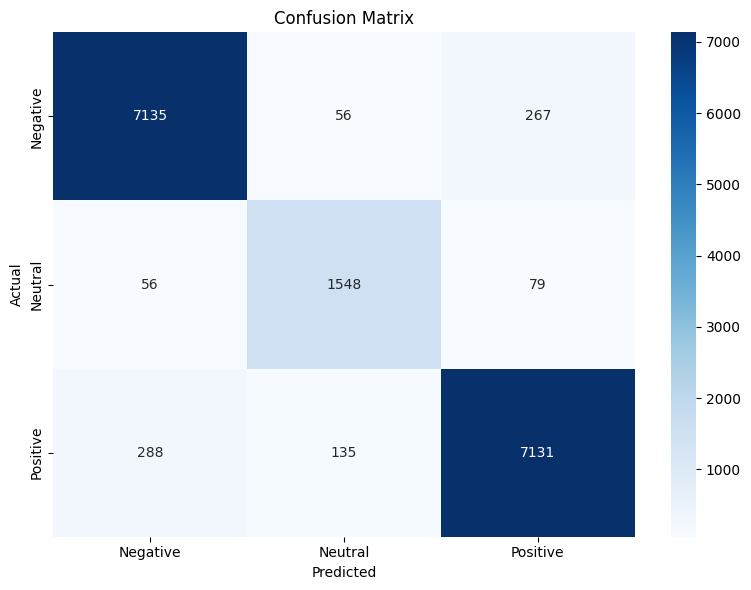

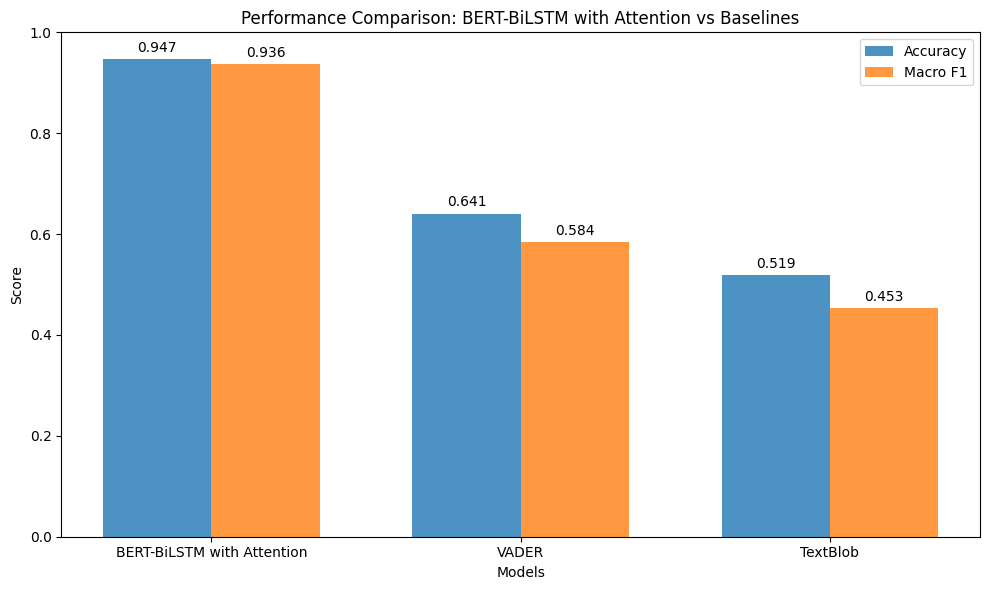

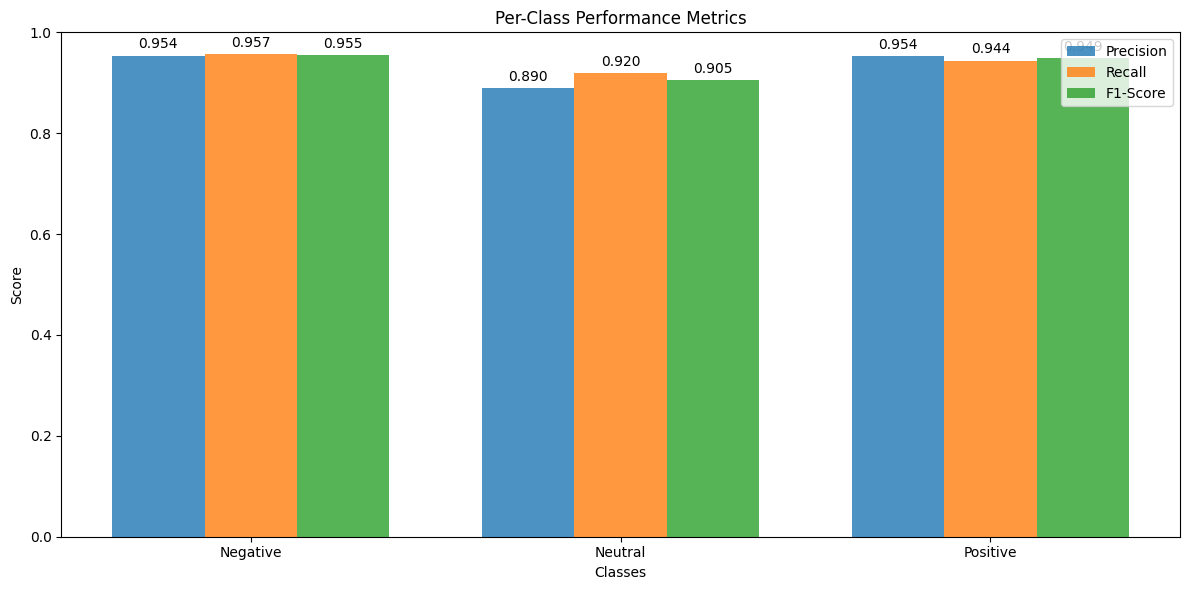

Visualizations completed!


In [29]:
def plot_confusion_matrix(cm, class_names, title="Confusion Matrix"):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.savefig(f"{config.results_dir}/confusion_matrix.png", dpi=300, bbox_inches='tight')
    plt.show()

def plot_performance_comparison(results, baseline_results):
    models = ['BERT-BiLSTM with Attention', 'VADER', 'TextBlob']
    accuracies = [
        results['accuracy'],
        baseline_results['vader']['accuracy'],
        baseline_results['textblob']['accuracy']
    ]
    f1_scores = [
        results['macro_f1'],
        baseline_results['vader']['f1'],
        baseline_results['textblob']['f1']
    ]
    
    x = np.arange(len(models))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(10, 6))
    bars1 = ax.bar(x - width/2, accuracies, width, label='Accuracy', alpha=0.8)
    bars2 = ax.bar(x + width/2, f1_scores, width, label='Macro F1', alpha=0.8)
    
    ax.set_xlabel('Models')
    ax.set_ylabel('Score')
    ax.set_title('Performance Comparison: BERT-BiLSTM with Attention vs Baselines')
    ax.set_xticks(x)
    ax.set_xticklabels(models)
    ax.legend()
    ax.set_ylim(0, 1)
    
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.3f}',
                       xy=(bar.get_x() + bar.get_width() / 2, height),
                       xytext=(0, 3),
                       textcoords="offset points",
                       ha='center', va='bottom')
    
    plt.tight_layout()
    plt.savefig(f"{config.results_dir}/performance_comparison.png", dpi=300, bbox_inches='tight')
    plt.show()

def plot_class_performance(results):
    class_names = ['Negative', 'Neutral', 'Positive']
    metrics = ['Precision', 'Recall', 'F1-Score']
    
    precision = results['precision']
    recall = results['recall']
    f1 = results['f1']
    
    x = np.arange(len(class_names))
    width = 0.25
    
    fig, ax = plt.subplots(figsize=(12, 6))
    bars1 = ax.bar(x - width, precision, width, label='Precision', alpha=0.8)
    bars2 = ax.bar(x, recall, width, label='Recall', alpha=0.8)
    bars3 = ax.bar(x + width, f1, width, label='F1-Score', alpha=0.8)
    
    ax.set_xlabel('Classes')
    ax.set_ylabel('Score')
    ax.set_title('Per-Class Performance Metrics')
    ax.set_xticks(x)
    ax.set_xticklabels(class_names)
    ax.legend()
    ax.set_ylim(0, 1)
    
    for bars in [bars1, bars2, bars3]:
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.3f}',
                       xy=(bar.get_x() + bar.get_width() / 2, height),
                       xytext=(0, 3),
                       textcoords="offset points",
                       ha='center', va='bottom')
    
    plt.tight_layout()
    plt.savefig(f"{config.results_dir}/class_performance.png", dpi=300, bbox_inches='tight')
    plt.show()

print("Generating visualizations...")

class_names = ['Negative', 'Neutral', 'Positive']
plot_confusion_matrix(results['confusion_matrix'], class_names)

plot_performance_comparison(results, baseline_results)

plot_class_performance(results)

print("Visualizations completed!")